In [62]:
import numpy as np
import pandas as pd
from os import path
import json
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
from pandas.tseries.offsets import MonthEnd
import geopandas as gpd
from shapely.ops import unary_union
from shapely.ops import split
import matplotlib.pyplot as plt
from shapely.geometry import box, Polygon, LineString, MultiPolygon
_HOME_ = path.expanduser("~") + "/PHD"
import modify_dataset

In [2]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [3]:
world = gpd.read_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")

In [4]:
italy = world.query("admin == 'Italy'").dissolve(by = "region", aggfunc="sum")

In [264]:
near_countries = ["France", "Switzerland", "Austria", "Slovenia", "Croatia", "Montenegro", "Bosnia and Herzegovina", "Albania", "Greece", "Austria", "Hungary", "Republic of Serbia", "Tunisia", "Algeria"]
gdf_surrounding = world.query("admin in @near_countries").dissolve(by = "admin", aggfunc="sum")

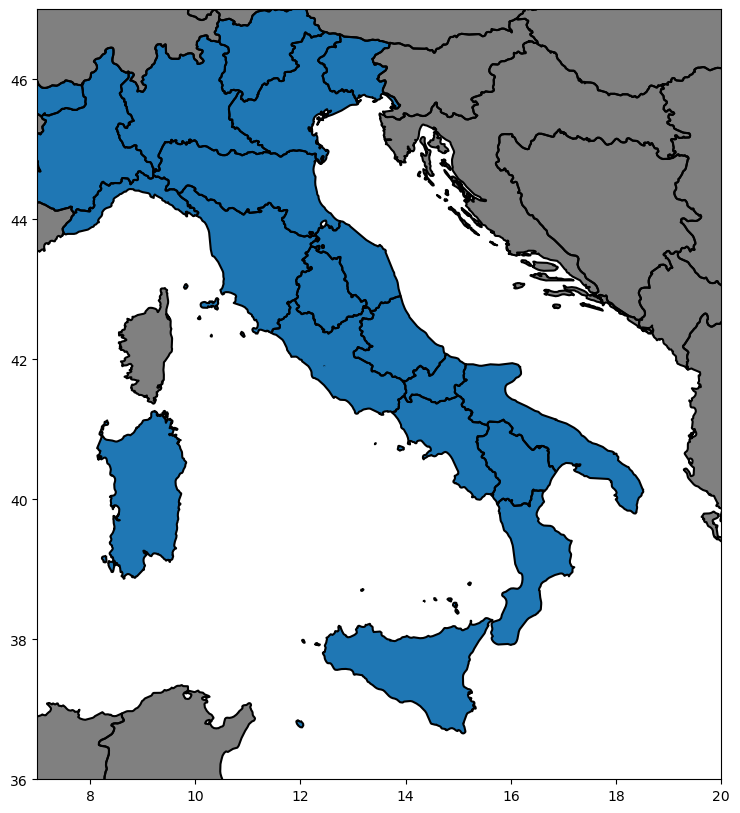

In [265]:
fig, ax = plt.subplots(figsize=(10, 10))

italy.boundary.plot(ax=ax, color='black')
#italy_countries.plot(column = "name_alt", ax=ax)
gdf_surrounding.plot(ax = ax, color = "grey")
gdf_surrounding.boundary.plot(ax = ax, color = "black")
italy.plot(ax = ax)
ax.set_xlim(7,20)
ax.set_ylim(36,47)

# Show the plot
plt.show()

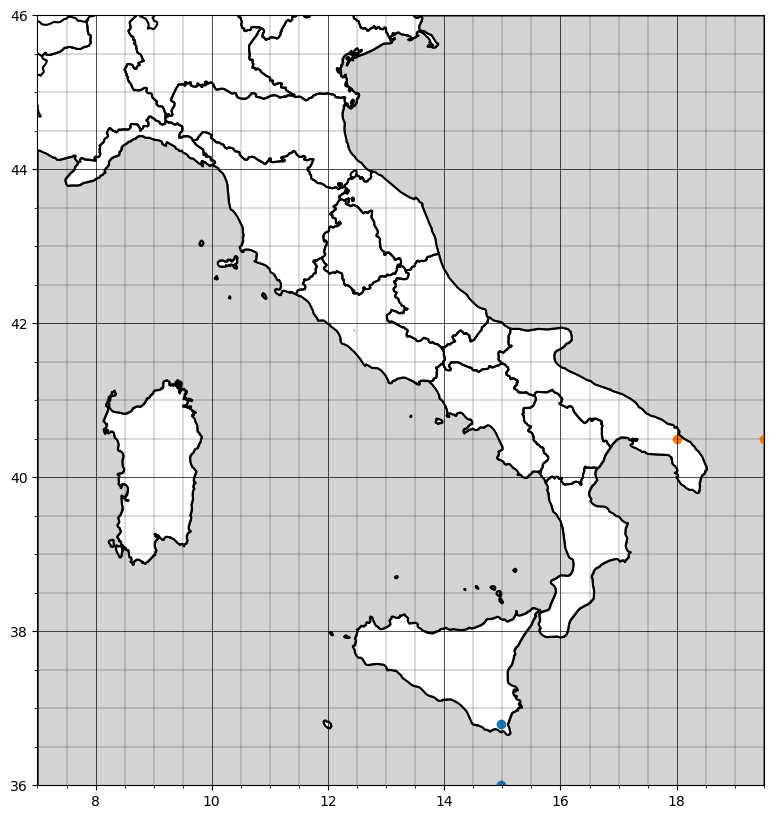

In [278]:
# Define the bounding box limits
x_min, x_max = 7, 19.5
y_min, y_max = 36, 46

bounding_box = box(x_min, y_min, x_max, y_max)


# Subtract italy geometries from the bounding box
outside_italy = bounding_box.difference(unary_union(italy.geometry))

# Create a new GeoDataFrame with the resulting polygon
outside_italy_gdf = gpd.GeoDataFrame(geometry=[outside_italy], crs=italy.crs).explode(index_parts = False)
outside_italy_gdf = gpd.GeoDataFrame(geometry = outside_italy_gdf.iloc[0,:]).reset_index(drop=True)
# Plot the result
fig, ax = plt.subplots(figsize=(10, 10))
italy.boundary.plot(ax=ax, color='black')
outside_italy_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

ax.scatter((14.979166030883789, 14.979166030883789), (ymin, 36.8))
ax.scatter((18, xmax), (40.5, 40.5))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle='-', linewidth='0.2', color='black')

In [279]:
xmin, ymin, xmax, ymax = outside_italy_gdf.bounds.to_numpy()[0]

In [410]:
coords = [
    ((xmin, 36.8), (xmax, 36.8)),  
    ((18, 40.041664123535156), (xmax, 40.041664123535156)),  
    ((14.979166030883789, ymin), (14.979166030883789, 41)), 
    ((9., ymin), (9., ymax)), 
    ((xmin, 41.291664123535156), (14, 41.291664123535156)), 
    ((13, 42.541664123535156), (xmax, 42.541664123535156)),
    ((15.4, 38.2), (15.8,38.2)), 
    ((xmin, 43.9), (9, 43.9))
]

# Create a MultiLineString from the coordinates
line_gdf = gpd.GeoDataFrame(geometry = list(map(lambda x: LineString([x[0], x[1]]), coords)), crs = outside_italy_gdf.crs)

In [411]:
polys_to_cut = [outside_italy_gdf.geometry[0]]
for line in list(map(lambda x: LineString([x[0], x[1]]), coords)):
    new_polys = []
    while (len(polys_to_cut) > 0):
        poly = polys_to_cut.pop(0)
        if line.intersects(poly) & ~line.touches(poly): 
            split_polys = split(poly, line)
            new_polys.extend(split_polys.geoms)
        else: 
            new_polys.append(poly)
    polys_to_cut = new_polys

In [421]:
partitions = gpd.GeoDataFrame(pd.DataFrame({"Basin" : np.arange(0,len(new_polys)).astype(str)}), geometry=new_polys, crs = gdf_surrounding.crs)
partitions = gpd.overlay(partitions, gdf_surrounding, how = "difference")

In [422]:
partition_centers = partitions.dissolve("Basin", aggfunc="mean").reset_index()
partition_centers["geometry"] =partition_centers["geometry"].geometry.to_crs(3857).centroid.to_crs(partition_centers.crs)

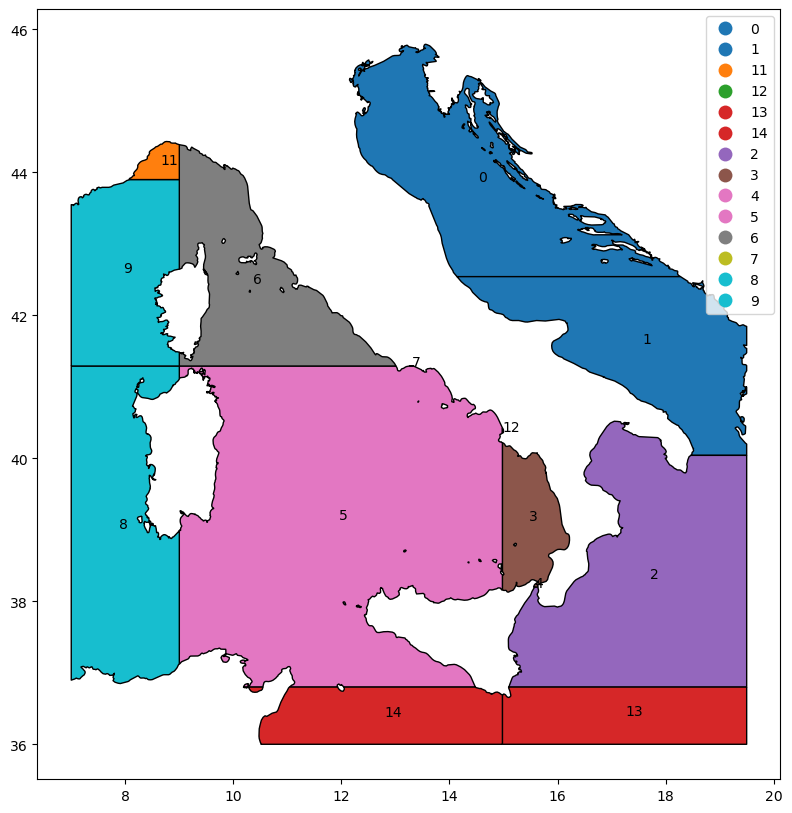

In [423]:
fig, ax = plt.subplots(figsize=(10, 10))
#italy.boundary.plot(ax=ax, color='black')
partitions.plot("Basin", ax=ax, edgecolor='black', legend=True)
for idx, row in partition_centers.iterrows(): 
    ax.text(row["geometry"].x, row["geometry"].y, row["Basin"], fontsize = 10)

In [424]:
partitions = partitions.loc[partitions["Basin"].isin(list(map(lambda x:  str(x), [0,1,2,3,5,6,8,9,8,11,13,14])))]

In [432]:
int_to_basin_name = {"0":"NorthAdr", "1":"SouthAdr", "2":"Ion", "13":"Ion", "14":"Ion", "3":"SouthTyr", "5": "SouthTyr", "6": "Lig", "11" : "Lig", "8": "WestMed", "9": "WestMed"}

In [433]:
partitions.loc[:, "Basin"] = partitions.loc[:, "Basin"].map(int_to_basin_name)

In [434]:
partitions = partitions.dissolve(by = "Basin", aggfunc="sum").reset_index()
partition_centers = partitions.dissolve("Basin", aggfunc="mean").reset_index()
partition_centers["geometry"] =partition_centers["geometry"].geometry.to_crs(3857).centroid.to_crs(partition_centers.crs)

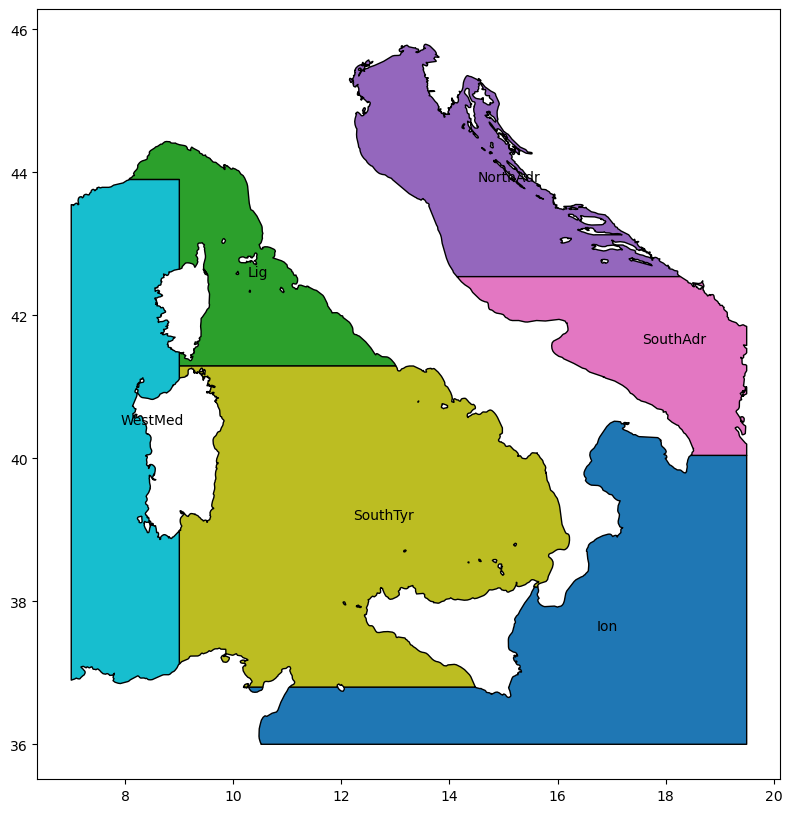

In [435]:
fig, ax = plt.subplots(figsize=(10, 10))
#italy.boundary.plot(ax=ax, color='black')
partitions.plot("Basin", ax=ax, edgecolor='black')
for idx, row in partition_centers.iterrows(): 
    ax.text(row["geometry"].x, row["geometry"].y, row["Basin"], fontsize = 10)

In [436]:
partitions.to_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/Basins.shp")

In [437]:
stations = phyto_abund_simplified.loc[:, ["id", "Longitude", "Latitude"]].drop_duplicates()

In [438]:
stations = gpd.GeoDataFrame(stations, geometry = gpd.points_from_xy(stations["Longitude"], stations["Latitude"]), crs = italy.crs)#.to_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/Stations.shp")

In [439]:
stations = gpd.sjoin(stations, partitions, how = "left", predicate = "within").loc[:, ["id", "Longitude", "Latitude", "Basin"]]

<Axes: xlabel='Longitude', ylabel='Latitude'>

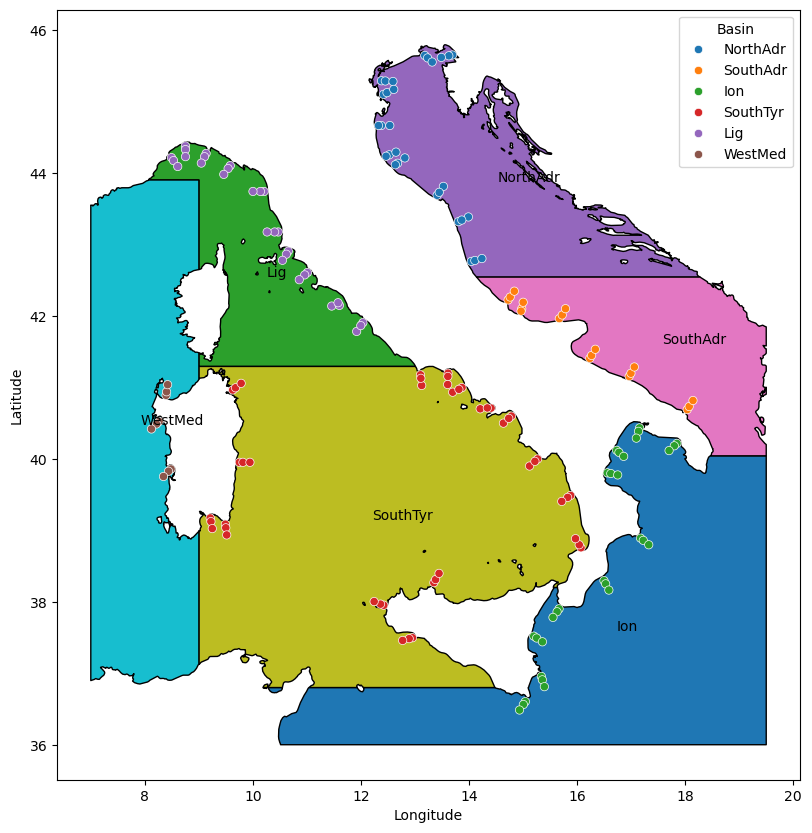

In [440]:
fig, ax = plt.subplots(figsize=(10, 10))
#italy.boundary.plot(ax=ax, color='black')
partitions.plot("Basin", ax=ax, edgecolor='black')
for idx, row in partition_centers.iterrows(): 
    ax.text(row["geometry"].x, row["geometry"].y, row["Basin"], fontsize = 10)
sns.scatterplot(data = stations, x = "Longitude", y = "Latitude", hue = "Basin", ax = ax)

In [442]:
stations.loc[:, ["id", "Basin"]].to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Stations_Basins.csv", index = False)

In [443]:
italy.to_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/Italy.shp")
gdf_surrounding.to_file(_HOME_ + "/ISPRA_20152017_Analysis/Description/Surrounding.shp")